# Sample queries exploring Graph structure in GEMD database


In [1]:
import SciServer.CasJobs as cj
from pprint import pprint
import json
import pandas

In [2]:
DATABASE='GEMD'

This query finds pairs of nodes with >1 path from one to the other.

In [3]:
%%time
sql="""
with gr as (
select c.uid as root_uid
,      c.gemd_type as root_type
,      0 as level
,      cast(NULL as varchar(64)) as endpoint_uid
,      cast(NULL as varchar(32)) as endpoint_type
,      c.uid as from_uid, cast(NULL as bigint) as edge_id, cast(NULL as varchar(64)) as gemd_ref
,      cast(gemd_type+c.uid as varchar(max)) as [path]
  from GEMDObject c where gemd_type='material_run'
 union all
select gr.root_uid, gr.root_type, gr.level+1, e.to_uid, c.gemd_type
,      e.to_uid, e.id, e.gemd_ref
,      gr.path+'==>'+e.gemd_ref+':'+e.to_uid
  from gr 
  join GEMDEdge e on e.from_uid=gr.from_uid
  join GEMDObject c on c.uid=e.to_uid
where gr.level < 16
)
select root_uid, root_type, endpoint_uid, endpoint_type
,      min(path) as path, min(level) as min_level, max(level) as max_level
,      count(*) as num_paths
  from gr
group by root_type, root_uid, endpoint_uid,endpoint_type having count(*) > 1  -- if you want to find multiple paths between nodes
 order by root_type,root_uid, endpoint_uid,path
"""
cj.executeQuery(sql, DATABASE)

CPU times: user 646 ms, sys: 437 ms, total: 1.08 s
Wall time: 15.4 s


,root_uid,root_type,endpoint_uid,endpoint_type,path,min_level,max_level,num_paths
0,000043d9-701d-4a81-bf62-4c1cb1cca72f,material_run,b6fbde0c-bbf3-44fc-ada9-ebd2dd07f69b,process_template,material_run000043d9-701d-4a81-bf62-4c1cb1cca7...,3,3,2
1,000043d9-701d-4a81-bf62-4c1cb1cca72f,material_run,b9274d86-b97a-4e39-b097-efee075e171a,process_spec,material_run000043d9-701d-4a81-bf62-4c1cb1cca7...,2,2,2
2,00027938-31ce-4580-af14-d8626e735d35,material_run,b6fbde0c-bbf3-44fc-ada9-ebd2dd07f69b,process_template,material_run00027938-31ce-4580-af14-d8626e735d...,3,3,2
3,00027938-31ce-4580-af14-d8626e735d35,material_run,f1556630-0f5c-4996-b016-36a4c822f9cb,process_spec,material_run00027938-31ce-4580-af14-d8626e735d...,2,2,2
4,0007c08e-c7f1-4568-bedc-543ebbc060df,material_run,8a150e80-4108-4ecf-9184-00000b40d06e,process_spec,material_run0007c08e-c7f1-4568-bedc-543ebbc060...,2,2,2
...,...,...,...,...,...,...,...,...
24197,ffdf443e-eed2-4c9a-a5ea-7ce1dd11ffc3,material_run,ee2196b4-b0eb-4c47-b2ff-4ba3fa58f25e,process_template,material_runffdf443e-eed2-4c9a-a5ea-7ce1dd11ff...,3,3,2
24198,ffe704e6-6c4f-4bfb-8930-7e87a61a0261,material_run,d5557c35-5104-4480-8a46-f093f8e8a4bb,process_template,material_runffe704e6-6c4f-4bfb-8930-7e87a61a02...,3,3,2
24199,ffe704e6-6c4f-4bfb-8930-7e87a61a0261,material_run,d6d849c4-5a00-4176-8b7c-0e0ac276e32e,process_spec,material_runffe704e6-6c4f-4bfb-8930-7e87a61a02...,2,2,2
24200,fff2d0fe-a165-4314-bb57-6608bc17c4f7,material_run,ee2196b4-b0eb-4c47-b2ff-4ba3fa58f25e,process_template,material_runfff2d0fe-a165-4314-bb57-6608bc17c4...,3,3,2


Following query returns all paths between all nodes. This can be compared with the graph functionality inside MS SQL itself but seems to be faster.

In [5]:
%%time
sql="""
with gr as (
select c.uid as root_uid
,      c.gemd_type as root_type
,      0 as level
,      cast(NULL as varchar(64)) as endpoint_uid
,      c.uid as from_uid, cast(NULL as bigint) as edge_id, cast(NULL as varchar(64)) as gemd_ref
,      cast(gemd_type+':'+c.uid as varchar(max)) as [path]
  from GEMDObject c
 union all
select gr.root_uid, gr.root_type, gr.level+1, e.to_uid
,      e.to_uid, e.id, e.gemd_ref
,      gr.path+'==>'+e.gemd_ref+':'+e.to_uid
  from gr
  join GEMDEdge e on e.from_uid=gr.from_uid
where gr.level < 16
)
select root_uid, root_type, endpoint_uid
,      edge_id,gemd_ref
,      path, level
  from gr
 order by root_type,root_uid, path
"""
paths=cj.executeQuery(sql, DATABASE)

Exception: Error when executing query. Http Response from CasJobs API returned status code 500:
{"Error Code":500,"Error Type":"InternalServerError","Error Message":"Failed to execute a query: Query results exceed memory limitations.   Please revise your query to return less information, or use MyDB","LogMessageID":"aea1ef6b-a45b-4f62-82e5-6f66a544ddfd"}

In [ ]:
edges=paths[paths['level']>0]
edges

count for each node how many distinct nodes can be reached from it

In [10]:
%%time
sql="""
with gr as (
select c.uid as root_uid
,      c.gemd_type as root_type
,      0 as level
,      cast(NULL as varchar(64)) as endpoint_uid
,      c.uid as from_uid, cast(NULL as bigint) as edge_id, cast(NULL as varchar(64)) as gemd_ref
,      cast(gemd_type+c.uid as varchar(max)) as [path]
  from GEMDObject c
 union all
select gr.root_uid, gr.root_type, gr.level+1, e.to_uid
,      e.to_uid, e.id, e.gemd_ref
,      gr.path+'==>'+e.gemd_ref+':'+e.to_uid
  from gr
  join GEMDEdge e on e.from_uid=gr.from_uid
where gr.level < 16
)
select root_uid, root_type, count(distinct endpoint_uid) as num_out_nodes
  from gr
group by root_type, root_uid
 order by num_out_nodes desc
"""
nodes_out=cj.executeQuery(sql, DATABASE)

CPU times: user 230 ms, sys: 76.4 ms, total: 306 ms
Wall time: 15.9 s


In [7]:
nodes_out.head(10)

,root_uid,root_type,num_out_nodes
0,adaa778f-62d8-476f-a774-4a3877a53d05,ingredient_run,13
1,e190aa30-a7d1-44c1-89a6-3262939803c4,ingredient_run,13
2,daea63f1-9ca9-4027-9c03-a1ac6c178342,ingredient_run,13
3,b8610aac-5b37-4b22-b17b-00262286fce7,ingredient_run,13
4,7d62501f-7a29-4c85-9fab-a869f6923bb2,ingredient_run,13
5,9cab251d-ff37-428c-97e2-77c725e825d6,ingredient_run,13
6,3ccc45be-c8b0-455c-a8e6-1f07472ff40c,ingredient_run,13
7,0b6a2404-634d-4868-be85-5fa90597b7c5,ingredient_run,13
8,300dc1dc-0fb0-40c5-a690-3a8c6545404d,ingredient_run,13
9,04b9166d-5cb6-4a0d-9e83-383a3fbfd6ab,ingredient_run,13


count for each node how many distinct nodes can reach it

In [40]:
%%time
sql="""
with gr as (
select c.uid as root_uid
,      c.gemd_type as root_type
,      0 as level
,      cast(NULL as varchar(64)) as endpoint_uid
,      c.uid as from_uid, cast(NULL as bigint) as edge_id, cast(NULL as varchar(64)) as gemd_ref
,      cast(gemd_type+c.uid as varchar(max)) as [path]
  from GEMDObject c
 union all
select gr.root_uid, gr.root_type, gr.level+1, e.to_uid
,      e.to_uid, e.id, e.gemd_ref
,      gr.path+'==>'+e.gemd_ref+':'+e.to_uid
  from gr
  join GEMDEdge e on e.from_uid=gr.from_uid
where gr.level < 16
)
select endpoint_uid, count(distinct root_uid) as num_in_nodes
  from gr
group by endpoint_uid
 order by num_in_nodes desc
"""
nodes_in=cj.executeQuery(sql, DATABASE)

CPU times: user 98.3 ms, sys: 19.2 ms, total: 118 ms
Wall time: 18.3 s


In [41]:
nodes_out.head()

,root_uid,root_type,num_out_nodes
0,adaa778f-62d8-476f-a774-4a3877a53d05,ingredient_run,13
1,e190aa30-a7d1-44c1-89a6-3262939803c4,ingredient_run,13
2,daea63f1-9ca9-4027-9c03-a1ac6c178342,ingredient_run,13
3,b8610aac-5b37-4b22-b17b-00262286fce7,ingredient_run,13
4,7d62501f-7a29-4c85-9fab-a869f6923bb2,ingredient_run,13


In [42]:
nodes_in.head()

,endpoint_uid,num_in_nodes
0,,50497
1,ee2196b4-b0eb-4c47-b2ff-4ba3fa58f25e,11597
2,abc629d5-7453-4620-accd-db59f8586067,9916
3,705961c4-081b-4cfb-ae02-d0c7eb3e2008,9683
4,b6fbde0c-bbf3-44fc-ada9-ebd2dd07f69b,8409


## visualize
Goal is to get a visualization vapability ala that supported by 
<a href="http://www.thebrain.com" target="_blank">http://www.thebrain.com</a>. \
This allows one to trace edges from a starting node, restricting views to only that node and nodes 1 or 2 steps away. \
Needs code development!

In [11]:
import networkx as nx
G = nx.Graph()

take a node from nodes_out and find the graph reachable from it

In [12]:
UID = nodes_out.iloc[0].root_uid
# UID = '01b44457-6ebe-43bc-b316-66fcff35957e'

In [17]:
sql=f"""
with gr as (
select c.uid as node_uid
,      c.gemd_type as node_type
,      c.context as node_context
,      cast(c.gemd_type+' ['+c.uid+']' as varchar(128)) as Target
,      cast(-1 as bigint) as edge_id
,      cast(NULL as varchar(64)) as from_uid
,      cast(NULL as varchar(128)) as Source
,      0 as level
  from GEMDObject c
  where uid='{UID}'
 union all
select c.uid as node_uid
,      c.gemd_type as node_type
,      c.context as node_context
,      cast(c.gemd_type+' ['+c.uid+']' as varchar(128)) as Target
,      e.id as edge_id
,      gr.node_uid as from_uid
,      gr.Target as Source
,      gr.level+1 as level
  from gr
  join GEMDEdge e on e.from_uid=gr.node_uid
  join GEMDObject c on c.uid=e.to_uid
where gr.level < 16
)
select Source,Target
--,node_type,node_context
  from gr
 where Source is not null
"""
gr=cj.executeQuery(sql,DATABASE)
gr

,Source,Target
0,ingredient_run [adaa778f-62d8-476f-a774-4a3877...,material_run [5c6e208a-7c91-49d5-a6ba-023911c3...
1,ingredient_run [adaa778f-62d8-476f-a774-4a3877...,ingredient_spec [276a2071-594e-4c36-bf81-a867c...
2,ingredient_run [adaa778f-62d8-476f-a774-4a3877...,process_run [58d4bf30-de0d-4972-8600-7dd33e71b...
3,process_run [58d4bf30-de0d-4972-8600-7dd33e71b...,process_spec [5c649b97-6770-487e-834d-c228a314...
4,process_spec [5c649b97-6770-487e-834d-c228a314...,process_template [ee2196b4-b0eb-4c47-b2ff-4ba3...
5,ingredient_spec [276a2071-594e-4c36-bf81-a867c...,material_spec [7595a295-533f-406a-8b0a-eccd4b1...
6,ingredient_spec [276a2071-594e-4c36-bf81-a867c...,process_spec [5c649b97-6770-487e-834d-c228a314...
7,process_spec [5c649b97-6770-487e-834d-c228a314...,process_template [ee2196b4-b0eb-4c47-b2ff-4ba3...
8,material_spec [7595a295-533f-406a-8b0a-eccd4b1...,process_spec [ed82e185-d722-4b3a-a72a-5c80d42a...
9,material_spec [7595a295-533f-406a-8b0a-eccd4b1...,material_template [44b8ff23-00dd-4551-8196-68c...


In [18]:
G=nx.from_pandas_edgelist(gr,'Source','Target',create_using=nx.DiGraph)#,'node_type')

In [17]:
G.nodes

NodeView(('ingredient_run [adaa778f-62d8-476f-a774-4a3877a53d05]', 'material_run [5c6e208a-7c91-49d5-a6ba-023911c32910]', 'ingredient_spec [276a2071-594e-4c36-bf81-a867cf78ce50]', 'process_run [58d4bf30-de0d-4972-8600-7dd33e71b070]', 'process_spec [5c649b97-6770-487e-834d-c228a314b77d]', 'process_template [ee2196b4-b0eb-4c47-b2ff-4ba3fa58f25e]', 'material_spec [7595a295-533f-406a-8b0a-eccd4b130760]', 'process_spec [ed82e185-d722-4b3a-a72a-5c80d42a476c]', 'material_template [44b8ff23-00dd-4551-8196-68cef7f02b96]', 'process_template [b33ea835-56e3-4b5e-88ba-eb17be32e4bd]', 'material_spec [e83b3018-8dea-439f-83bb-ae35c0cb1c94]', 'process_run [cc7b3c40-af3e-41c8-844b-7315cd01ab54]', 'process_spec [aba8d3b2-4103-4993-8c3b-6fa0774b721c]', 'process_template [66157c71-b4b4-42a6-8354-c9a698c8e4db]'))

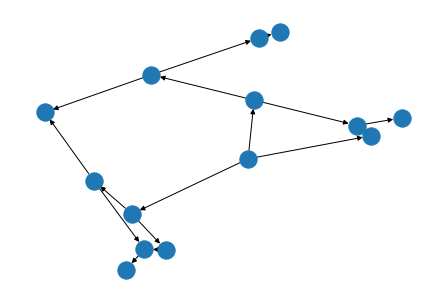

In [18]:
nx.draw_spring(G)  # seems not to work in JupyterLab

## plot using bokeh
Needs more work. Canot deal with DiGraphs

In [19]:
from bokeh.io import output_notebook, show, save
from bokeh.models import Range1d, Circle, ColumnDataSource, MultiLine
from bokeh.plotting import figure
from bokeh.plotting import from_networkx

In [20]:
output_notebook()

Loading BokehJS ...

In [21]:
#Choose a title!
title = f'graph rooted in {UID}'

#Establish which categories will appear when hovering over each node
HOVER_TOOLTIPS = [("Source", "@index")]

#Create a plot — set dimensions, toolbar, and title
plot = figure(tools="pan,wheel_zoom,save,reset", active_scroll='wheel_zoom',
              tooltips = HOVER_TOOLTIPS,
              x_range=Range1d(-10.1, 10.1), y_range=Range1d(-10.1, 10.1), title=title)

#Create a network graph object with spring layout
# https://networkx.github.io/documentation/networkx-1.9/reference/generated/networkx.drawing.layout.spring_layout.html
network_graph = from_networkx(G, nx.spring_layout, scale=10, center=(0, 0))

#Set node size and color
network_graph.node_renderer.glyph = Circle(size=15, fill_color='skyblue')

#Set edge opacity and width
network_graph.edge_renderer.glyph = MultiLine(line_alpha=0.5, line_width=1)

#Add network graph to the plot
plot.renderers.append(network_graph)

show(plot)
# save(plot, filename=f"{title}.html")

## plot using netgraph
Seeming problems in JupyterLab

In [22]:
pip install netgraph

Note: you may need to restart the kernel to use updated packages.


In [23]:
import netgraph # 

In [24]:
%matplotlib notebook
import IPython

In [ ]:
import numpy as np
import matplotlib.pyplot as plt; plt.ion()
import networkx


# Construct sparse, directed, weighted graph
total_nodes = 20
weights = np.random.rand(total_nodes, total_nodes)
connection_probability = 0.1
is_connected = np.random.rand(total_nodes, total_nodes) <= connection_probability
graph = np.zeros((total_nodes, total_nodes))
graph[is_connected] = weights[is_connected]

# construct a networkx graph
# g = networkx.from_numpy_array(graph, networkx.DiGraph)

# decide on a layout
pos = networkx.layout.spring_layout(G)

# Create an interactive plot.
# NOTE: you must retain a reference to the object instance!
# Otherwise the whole thing will be garbage collected after the initial draw
# and you won't be able to move the plot elements around.
plot_instance = netgraph.InteractiveGraph(G, node_positions=pos)

######## drag nodes around #########

# To access the new node positions:
node_positions = plot_instance.node_positions

## display using pydot
Not interactive.

In [ ]:
%pip install pydot

In [26]:
import pydot
from IPython.display import Image, display

def view_pydot(pdot):
    plt = Image(pdot.create_png())
    display(plt)

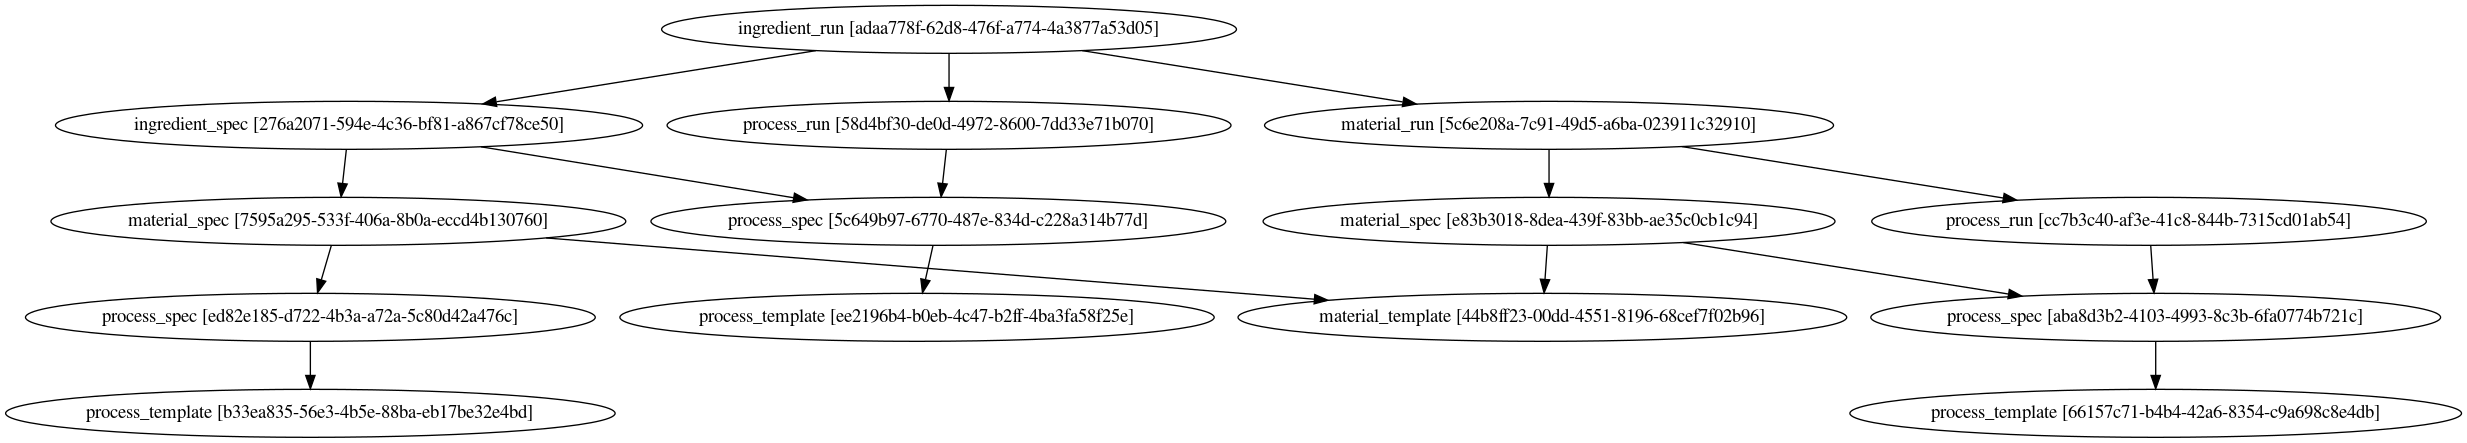

In [27]:
dotG=nx.nx_pydot.to_pydot(G)
view_pydot(dotG)

# yfiles_jupyter_graphs

In [13]:
from yfiles_jupyter_graphs import GraphWidget
from networkx import Graph, DiGraph, MultiGraph, MultiDiGraph, path_graph

In [20]:
def _widget(graph):
    # helper function
    # print(graph)
    # print('-'*40)
    return GraphWidget(graph = graph)

In [25]:
GraphWidget(graph=G)

GraphWidget(layout=Layout(height='500px', width='100%'))

In [22]:
def make_graph(graph_class):
    G = graph_class(day="Friday")
    G.add_node("origin")
    G.add_node(1)
    G.add_nodes_from([2, 3])
    H = path_graph(10)
    G.add_nodes_from(H)
    G.add_edge(1, 2)
    G.add_edges_from([(1, 2), (1, 3)])
    G.add_edges_from(H.edges)
    G.add_node(1, time="5pm")
    G.add_nodes_from([3], time="2pm")
    for n in G.nodes:
        G.add_edge("origin", n)
    G.nodes[1]["room"] = 714
    G.add_edge(1, 2, weight=4.7)
    G.add_edges_from([(3, 4), (4, 5)], color="red")
    G.add_edges_from([(1, 2, {"color": "blue"}), (2, 3, {"weight": 8})])
    G[1][2]["weight"] = 4.7
    G.edges[1, 2]["weight"] = 4
    return G

In [26]:
GraphWidget(graph = make_graph(DiGraph))

GraphWidget(layout=Layout(height='500px', width='100%'))